## Project description

<div class="paragraph">You work for the online store Ice, which sells videogames all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This allows you to put your money on a potentially hot new item and plan advertising campaigns.</div><div class="paragraph">In front of you is data going back to 2016. Let’s imagine that it’s December 2016 and you’re planning a campaign for 2017. </div><div class="paragraph">The important thing is to get experience working with data. It doesn't really matter whether you're forecasting 2017 sales based on data from 2016 or 2027 sales based on data from 2026.</div><div class="paragraph">The data set contains the abbreviation <em>ESRB (</em>Entertainment Software Rating Board<em>)</em>. The ESRB evaluates a game's content and assigns an appropriate age categories, such as Teen and Mature.</div>

In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f as f_test
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

## 1. Open the data file and study the general information

<div class="markdown markdown_size_normal markdown_type_theory theory-viewer__markdown"><h3>Data description</h3><div class="paragraph">—<em>Name</em> </div><div class="paragraph">—<em>Platform</em> </div><div class="paragraph">—<em>Year_of_Release</em> </div><div class="paragraph">—<em>Genre</em> </div><div class="paragraph">—<em>NA_sales</em> (North American sales in USD million) </div><div class="paragraph">—<em>EU_sales</em> (sales in Europe in USD million) </div><div class="paragraph">—<em>JP_sales</em> (sales in Japan in USD million) </div><div class="paragraph">—<em>Other_sales</em> (sales in other countries in USD million) </div><div class="paragraph">—<em>Critic_Score</em> (maximum of 100) </div><div class="paragraph">—<em>User_Score</em> (maximum of 10) </div><div class="paragraph">—<em>Rating</em> (ESRB)</div><div class="paragraph">Data for 2016 may be incomplete.</div></div>

In [392]:
datafile = "https://code.s3.yandex.net/datasets/games.csv"

In [393]:
df = pd.read_csv(datafile)

In [394]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [395]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

## 2. Prepare the data

<ul><li>Replace the column names (make them lowercase).</li><li>Convert the data to the required types.</li><li>Describe the columns where the data types have been changed and why.</li><li>If necessary, decide how to deal with missing values:
  <ul><li>Explain why you filled in the missing values as you did or why you decided to leave them blank.</li><li>Why do you think the values are missing? Give possible reasons.</li><li>Pay attention to the abbreviation TBD (to be determined) in the rating column. Specify how you intend to handle such cases.</li></ul></li><li>Calculate the total sales (the sum of sales in all regions) for each game and put these values in a separate column.</li></ul>

In [396]:
df.columns = df.columns.str.lower()

In [397]:
df.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

In [398]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [399]:
#missing value ratio
def missing_values(df):
    df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
    df_nulls.columns = ["type","count","missing_ratio"]
    df_nulls=df_nulls[df_nulls["count"]>0]
    df_nulls.sort_values(by="missing_ratio", ascending=False)
    return df_nulls

#outliers by 3 sigma rule
def outlier(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return len(outliers)

# full description statistics 
def describe_full(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    data_describe['outliers']=[outlier(df_numeric[col]) for col in df_numeric.columns]
    data_describe['kurtosis']=df_numeric.kurtosis()
    return data_describe

def plt_missing_data(df):
    data_null = df.isnull().sum()/len(df)
    data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)
    plt.subplots(figsize=(40,10))
    plt.xticks(rotation='90')
    sns.barplot(data_null.index, data_null)
    plt.xlabel('Features', fontsize=20)
    plt.ylabel('Missing rate', fontsize=20)

In [400]:
missing_values(df)

,type,count,missing_ratio
name,object,2,0.000120
year_of_release,float64,269,0.016093
genre,object,2,0.000120
critic_score,float64,8578,0.513192
user_score,object,6701,0.400897
rating,object,6766,0.404786


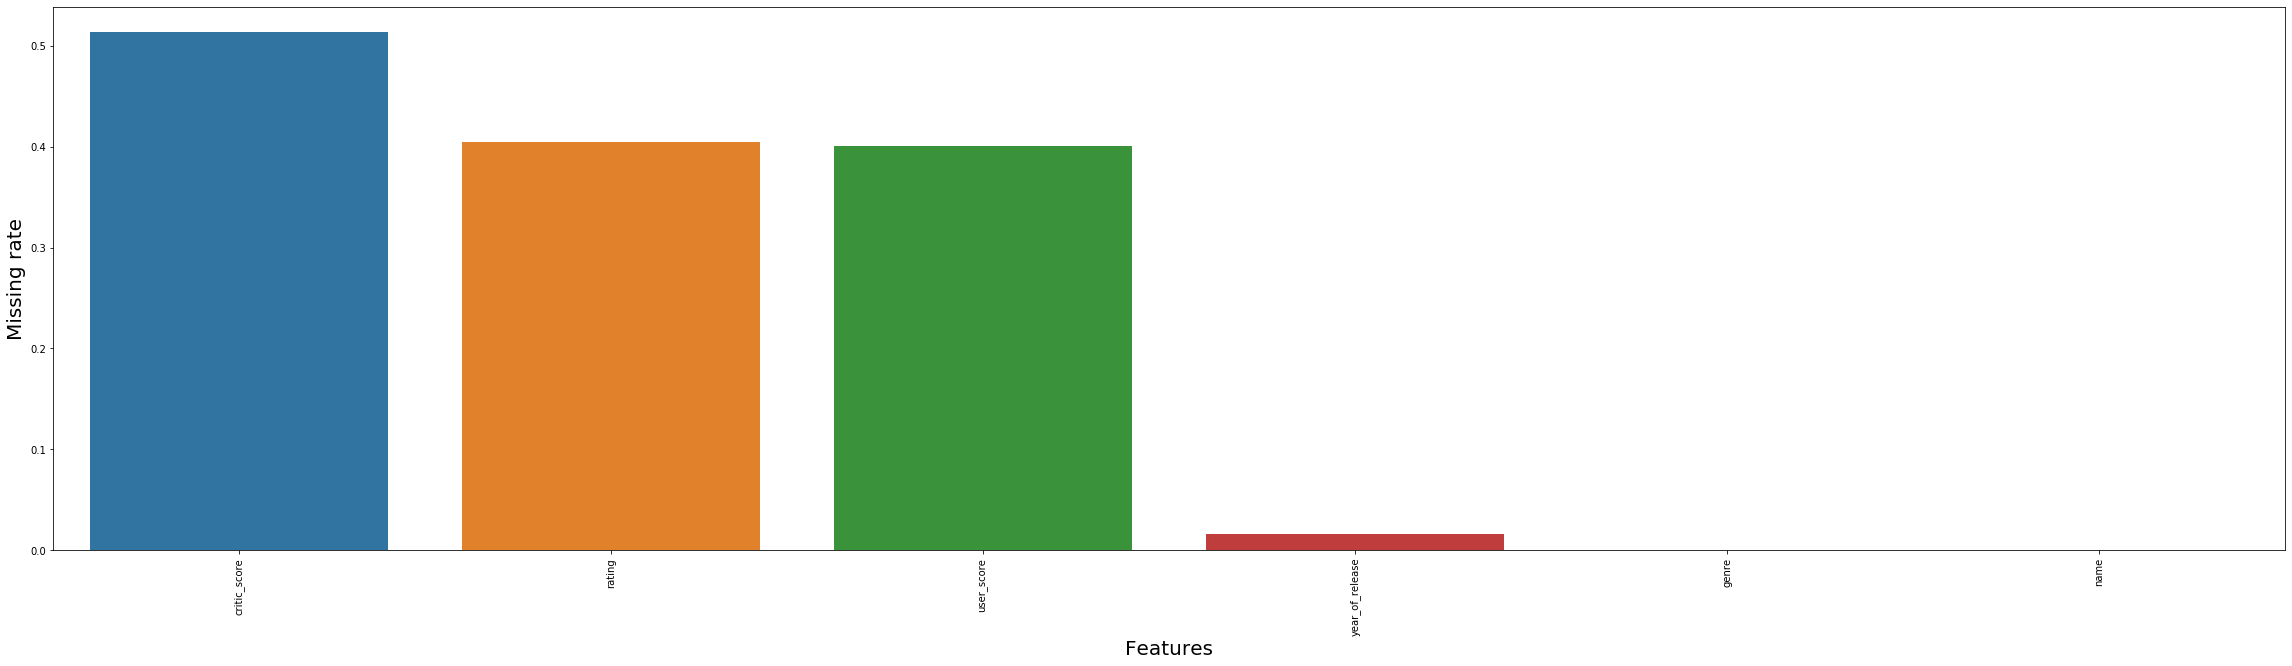

In [401]:
plt_missing_data(df)

 as we see we have 6 columns with missing value, user_score and rating have almost the same, genre and name are also

In [402]:
describe_full(df).T

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,16446,16715,16715,16715,16715,8137
mean,2006.48,0.263377,0.14506,0.0776171,0.0473419,68.9677
std,5.87705,0.813604,0.503339,0.308853,0.186731,13.9382
min,1980,0,0,0,0,13
25%,2003,0,0,0,0,60
50%,2007,0.08,0.02,0,0.01,71
75%,2010,0.24,0.11,0.04,0.03,79
max,2016,41.36,28.96,10.22,10.57,98
dtypes,float64,float64,float64,float64,float64,float64
Missing %,1.60933,0,0,0,0,51.3192


as we could see, _sales columns are strongly skew

In [403]:
col_sales = ['na_sales', 'eu_sales', 'eu_sales', 'jp_sales', 'other_sales']
df["all_sales"] = df[col_sales].sum(axis=1)

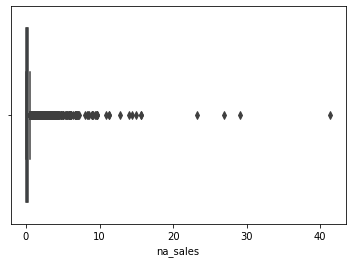

In [404]:
sns.boxplot(df["na_sales"])

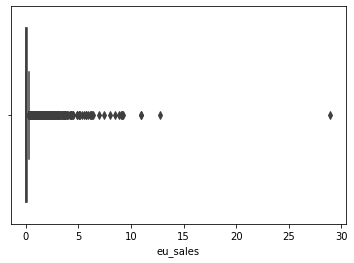

In [405]:
sns.boxplot(df["eu_sales"])

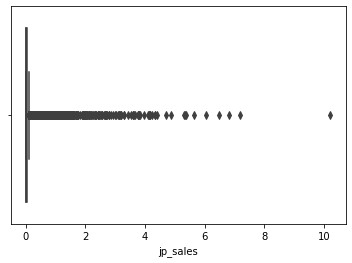

In [406]:
sns.boxplot(df["jp_sales"])

In [407]:
df["platform"].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

I think it's better to convert year from float to int, for simplicity of comparing and etc. (we could also convert to datetime, but in this case it's not matter) But first of all we need to deal with impute missing values

In [408]:
df_missing_year = df[:][df["year_of_release"].isna()].reset_index().drop_duplicates()
df_missing_year

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,5.50
1,377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,5.86
2,456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+,4.03
3,475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,4.02
4,609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,2.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+,0.01
265,16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T,0.01
266,16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M,0.01
267,16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


I didn't see any pattern of missing year. 

In [409]:
df[df["name"]=="Madden NFL 2004"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E,5.50
1881,Madden NFL 2004,XB,2003.0,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E,1.11
3889,Madden NFL 2004,GC,2003.0,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E,0.61
5708,Madden NFL 2004,GBA,2003.0,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E,0.39


In [410]:
df[df["name"]=="Space Invaders"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN,2.67
4264,Space Invaders,SNES,1994.0,Shooter,0.00,0.00,0.46,0.00,NaN,NaN,NaN,0.46
8580,Space Invaders,N64,1999.0,Shooter,0.13,0.03,0.00,0.00,NaN,NaN,NaN,0.19
10383,Space Invaders,GBA,2002.0,Shooter,0.08,0.03,0.00,0.00,NaN,NaN,NaN,0.14


In [411]:
df_missing_year[["name"]].drop_duplicates()

,name
0,Madden NFL 2004
1,FIFA Soccer 2004
2,LEGO Batman: The Videogame
3,wwe Smackdown vs. Raw 2006
4,Space Invaders
...,...
262,Brothers in Arms: Furious 4
263,Agarest Senki: Re-appearance
265,Freaky Flyers
266,Inversion


In [412]:
map_name_year = {r["name"]:r["year_of_release"] for _, r in (df_missing_year[["name"]]
 .drop_duplicates()
 .merge(df[~df["year_of_release"].isna()][["name", "year_of_release"]], how="inner").drop_duplicates()).iterrows()}

In [413]:
df["year_of_release"] = df["year_of_release"].fillna(df["name"].map(map_name_year))

In [414]:
df[df["year_of_release"].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,4.02
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T,2.80
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E,2.58
805,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T,2.65
1142,Rock Band,PS3,NaN,Misc,0.99,0.41,0.00,0.22,92.0,8.4,T,2.03
...,...,...,...,...,...,...,...,...,...,...,...,...
16277,Homeworld Remastered Collection,PC,NaN,Strategy,0.00,0.01,0.00,0.00,86.0,8.2,E10+,0.02
16288,Shorts,DS,NaN,Platform,0.01,0.00,0.00,0.00,NaN,tbd,E10+,0.01
16348,Agarest Senki: Re-appearance,PS3,NaN,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


we filled only part of missing values of the years, by name. let's fill the remaining by the minimum. (worse case) but before need to check minimum (as we saw before, we have strange year as minimum)

In [415]:
df[df["year_of_release"]==df["year_of_release"].min()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
262,Asteroids,2600,1980.0,Shooter,4.00,0.26,0.0,0.05,NaN,NaN,NaN,4.57
546,Missile Command,2600,1980.0,Shooter,2.56,0.17,0.0,0.03,NaN,NaN,NaN,2.93
1764,Kaboom!,2600,1980.0,Misc,1.07,0.07,0.0,0.01,NaN,NaN,NaN,1.22
1968,Defender,2600,1980.0,Misc,0.99,0.05,0.0,0.01,NaN,NaN,NaN,1.10
2650,Boxing,2600,1980.0,Fighting,0.72,0.04,0.0,0.01,NaN,NaN,NaN,0.81
4019,Ice Hockey,2600,1980.0,Sports,0.46,0.03,0.0,0.01,NaN,NaN,NaN,0.53
5360,Freeway,2600,1980.0,Action,0.32,0.02,0.0,0.00,NaN,NaN,NaN,0.36
6300,Bridge,2600,1980.0,Misc,0.25,0.02,0.0,0.00,NaN,NaN,NaN,0.29
6875,Checkers,2600,1980.0,Misc,0.22,0.01,0.0,0.00,NaN,NaN,NaN,0.24


I assume it's also missing values. Also there are missing values at the 3rd columns - critic_score	user_score	rating. as we see, sales columns have low values of saling. Let's drop this column

In [416]:
df = df.drop(df[df["year_of_release"]==df["year_of_release"].min()].index)

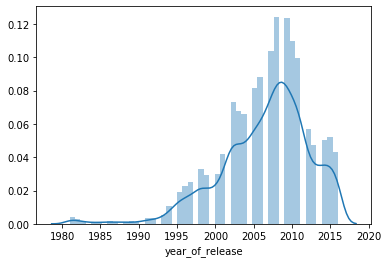

In [417]:
sns.distplot(df["year_of_release"])

we have skewness, and according to business model, data that is before 2000, has uncertainty impact on current (2016) picture. Also there are a lot of missing values around this years and it's logically correct 

In [418]:
df[(df["year_of_release"]<1995) & (df["all_sales"]<10)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
89,Pac-Man,2600,1982.0,Puzzle,7.28,0.45,0.00,0.08,NaN,NaN,NaN,8.26
98,Super Mario Bros. 2,NES,1988.0,Platform,5.39,1.18,0.70,0.19,NaN,NaN,NaN,8.64
124,The Legend of Zelda,NES,1986.0,Action,3.74,0.93,1.69,0.14,NaN,NaN,NaN,7.43
137,Street Fighter II: The World Warrior,SNES,1992.0,Fighting,2.47,0.83,2.87,0.12,NaN,NaN,NaN,7.12
145,Sonic the Hedgehog 2,GEN,1992.0,Platform,4.47,1.20,0.16,0.19,NaN,NaN,NaN,7.22
...,...,...,...,...,...,...,...,...,...,...,...,...
15551,Mortal Kombat,PC,1994.0,Fighting,0.02,0.00,0.00,0.00,NaN,NaN,NaN,0.02
15692,Empire Deluxe,PC,1992.0,Strategy,0.02,0.00,0.00,0.00,NaN,NaN,NaN,0.02
15788,World Class Rugby 2: Kokunai Gekitou Hen '93,SNES,1994.0,Sports,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02
15957,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02


If necessary, decide how to deal with missing values:
Explain why you filled in the missing values as you did or why you decided to leave them blank.
Why do you think the values are missing? Give possible reasons.
Pay attention to the abbreviation TBD (to be determined) in the rating column. Specify how you intend to handle such cases.
Calculate the total sales (the sum of sales in all regions) for each game and put these values in a separate column.

In [419]:
df[df["genre"].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.92
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03


It's also incorrect rows, it's old rows, don't have name, and a lot of columns. we couldn't impute it in a right way

In [420]:
df = df.drop(df[df["genre"].isna()].index)

In [421]:
df.isna().sum()

name                  0
platform              0
year_of_release     146
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8567
user_score         6690
rating             6755
all_sales             0
dtype: int64

In [422]:
df.loc[df["year_of_release"].isna(), "year_of_release"] = df["year_of_release"].min()

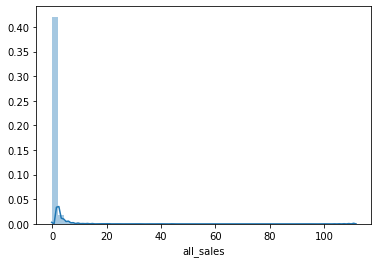

In [423]:
sns.distplot(df["all_sales"])

In [424]:
df[df["critic_score"].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,43.82
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,40.27
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,32.52
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.94
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,35.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.02
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


I think best score it's sales;)

In [425]:
df.loc[df["critic_score"].isna(), "critic_score"] = df[df["critic_score"].isna()]["all_sales"].astype(int)

In [426]:
df["user_score"].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [427]:
df["rating"].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [428]:
df["year_of_release"] = df["year_of_release"].astype(int)

as we see we have "to be determined" user score. it's similar to nan in our case and for our model we could replace it by negative 1

In [429]:
df['user_score'] = df['user_score'].fillna(-1)
df['user_score'] = df['user_score'].replace('tbd', -1)
df['critic_score'] = df['critic_score'].fillna(-1)

In [430]:
df['user_score'] = df['user_score'].astype('float')

In [431]:
df["genre"] = df["genre"].str.lower()
# df["genre"] = df["genre"].astype("category")

we don't know rating of missied row, let's create another category for that. also because there are a lot of rows like that

* EC - Early childhood
* E - Everyone
* E10+ - Everyone 10 and older
* T -Teen
* M - Mature
* AO - Adults Only 18+ 
* RP - Rating Pending 


In [432]:
df.loc[df["rating"].isna(), "rating"] = "NA"

In [433]:
df.duplicated().sum()

0

### Summary

* We found missing values. Missing values by years were restored by name of games partially and some of them were filled by min value
* Missing values of users and critics were replaced by negative value, we couldn't delete them and we couldn't fill them by some value logically
* Also types of year, uuser_score, critic_score were converted to numerical types, and genre was converted as category 


## 3. Analyze the data

<ul><li>Look at how many games were released in different years. Is the data for every period significant?</li><li>Look at how sales varied from platform to platform. Choose the platforms with the greatest total sales and build a distribution based on data for each year. Find platforms that used to be popular but now have zero sales. How long does it generally take for new platforms to appear and old ones to fade?</li><li>Determine what period you should take data for<strong>.</strong> To do so, look at your answers to the previous questions. The data should allow you to build a prognosis for 2017.</li><li>Work only with the data that you've decided is relevant. Disregard the data for previous years.</li><li>Which platforms are leading in sales? Which ones are growing or shrinking? Select several potentially profitable platforms.</li><li>Build a box plot for the global sales of each game, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings.</li><li>Take a look at how user and professional reviews affect sales for a particular popular platform. Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.</li><li>Keeping your conclusions in mind, compare the sales of the same games on other platforms.</li><li>Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales?</li></ul>

[Text(0, 0.5, 'count'), Text(0.5, 0, 'year')]

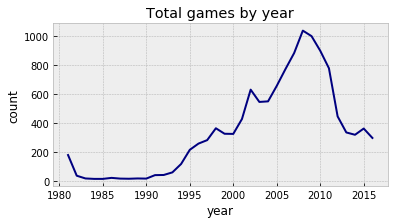

In [434]:
with plt.style.context('bmh'): 
    ((df[['name', 'year_of_release']]
        .drop_duplicates()
        .pivot_table(index='year_of_release', values='name', aggfunc='count')
        .sort_values('year_of_release', ascending=False))
        .plot(figsize=(6, 3), colormap='jet', legend=False, title='Total games by year')
        .set(xlabel='year', ylabel='count'))

as we predicted before, and already saw, data before 1995-2000 is not interested for us, it's old games. also it's incorrect from economic view, cost of money was changed. also we could see how trends were changed. probably after 2008-2010 people play more in online game which as I think, are not represented in the dataset 

[Text(0, 0.5, 'sum of sales'), Text(0.5, 0, 'platform')]

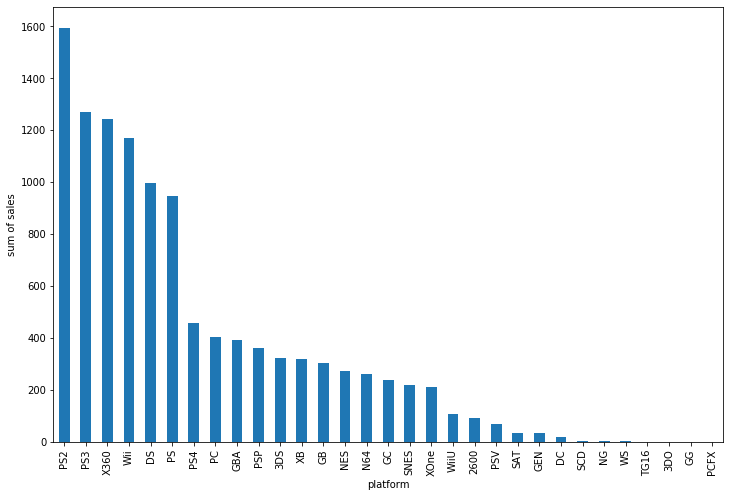

In [333]:
((df.pivot_table(index='platform', values='all_sales', aggfunc='sum')
         .sort_values('all_sales', ascending=False))
   .plot(kind='bar', y='all_sales', figsize=(12, 8), legend=False)
            .set(xlabel='platform', ylabel='sum of sales'))
plt.show()

In [334]:
def display_group_density_plot(df, groupby, on, palette, figsize):
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """

    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    # Plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')

    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on], \
                    shade=True, color=color, label=value)

    ax.set_title(str("Distribution of " + on + " per " + groupby + " group"),\
                 fontsize=30)
    
    ax.set_xlabel(on, fontsize=20)
    return ax 

let's find most saling platform

In [335]:
top10_platforms = (df
 .pivot_table(index='platform', values='all_sales', aggfunc='sum')
 .sort_values('all_sales', ascending=False)).head(10)
top10_platforms

,all_sales
platform,
PS2,1595.06
PS3,1269.94
X360,1242.18
Wii,1169.72
DS,995.01
PS,944.47
PS4,455.23
PC,401.96
GBA,393.10


and plot density plot for them

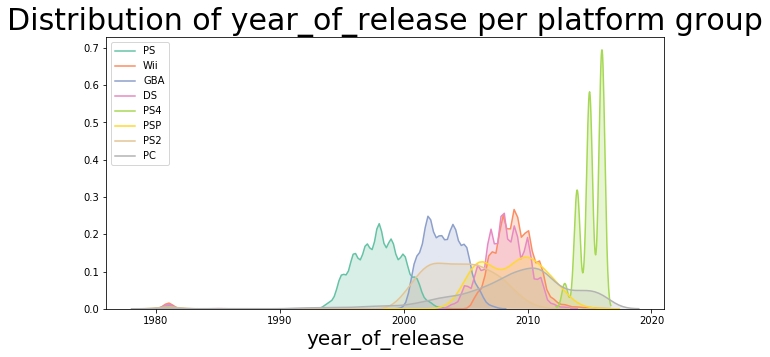

In [336]:
display_group_density_plot(df[df["platform"].isin(top10_platforms.index)], groupby = "platform", on = 'year_of_release', \
                                           palette = sns.color_palette('Set2'), 
                           figsize = (10, 5))

as we see some of platforms were popular in different time of perid. and non of top 10 platforms by saling were not popular on period before 1995

In [337]:
df = df[(df['year_of_release'] > 1995) & (df['year_of_release'] <= 2016)]

In [338]:
all_sales_per_platform =df.pivot_table(index='platform', values='all_sales', aggfunc='sum').sort_values('all_sales', ascending=False)

In [339]:
platforms = list(all_sales_per_platform.index)

let's plot sales for different platforms

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

[Text(0, 0.5, 'all sales'), Text(0.5, 0, 'year_of_release')]

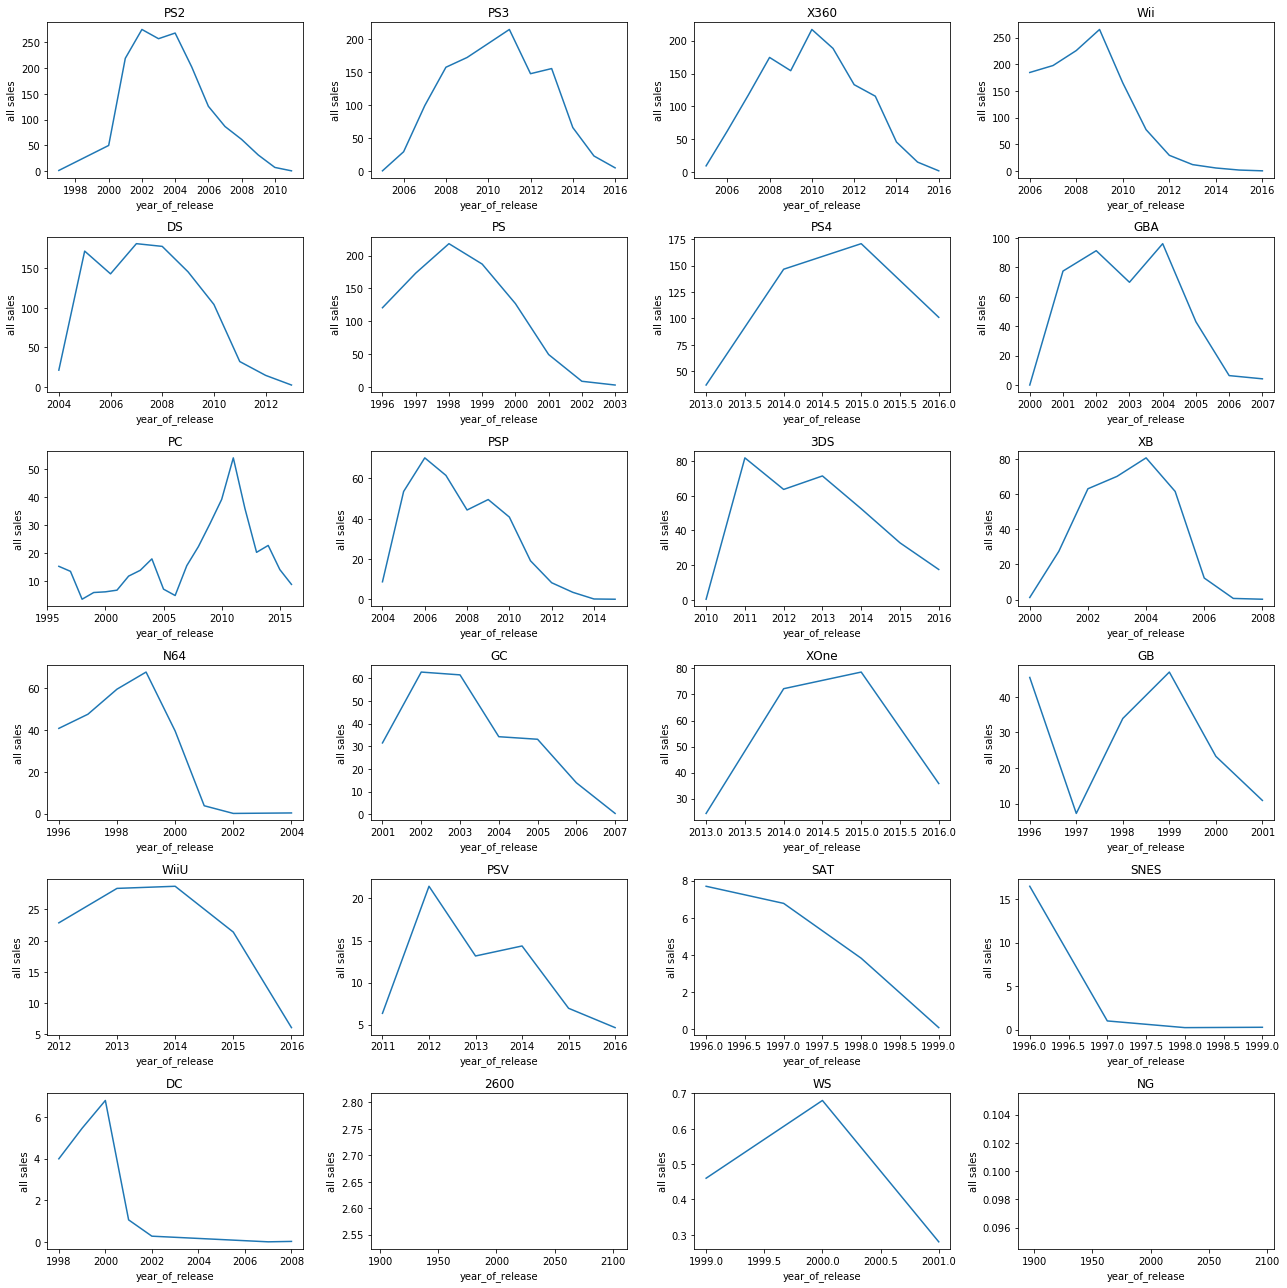

In [340]:
fig, axs = plt.subplots(6, len(platforms) // 6)
axs = axs.flatten()

num = 0
for platform, ax in zip(platforms, axs):
     ((df[df["platform"]==platform]
            .pivot_table(index='year_of_release', values='all_sales', aggfunc='sum')
            .sort_values('year_of_release', ascending=False))['all_sales']
                .plot(ax=ax, figsize=(18, 18), title=platform)
                .set(xlabel='year_of_release', ylabel='all sales'))
   
    
plt.tight_layout()
plt.show()

according plots, as we assumed before a lot of sales was decreased. some of platforms like WS are gone. "2600" it's something strange
PS4 is popular comaring to others.

## 4. Create a user profile for each region

<div class="paragraph">For each region (NA, EU, JP), determine:</div><ul><li>The top five platforms. Describe variations in their market shares from region to region.</li><li>The top five genres. Explain the difference.</li><li>Do ESRB ratings affect sales in individual regions?</li></ul>

In [341]:
def plot_top_sales_by_region_barplot(df, column, region, n=5):
    data = (df
            .pivot_table(index=column, values=region, aggfunc='sum')
            .sort_values(region, ascending=False)
            .head(n)).reset_index()
    sns.set_color_codes("pastel")
    sns.barplot(y=data[column], x=data[region], data=data, label="sales")
    sns.set_color_codes("muted")
    plt.show()

In [368]:
def plot_top_sales_by_region_pie(df, column, region, n=5):
    data = (df
            .pivot_table(index=column, values=region, aggfunc='sum')
            .sort_values(region, ascending=False)
            .head(n))
    data.plot(kind='pie', y=region,autopct='%1.0f%%', figsize=(10, 5), legend=True).set(label=data.index)
    plt.show()

#### NA / North America

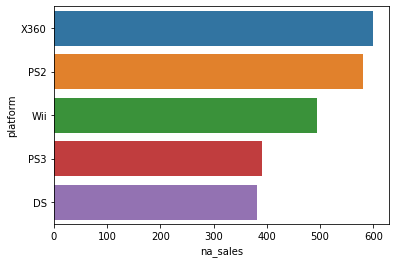

In [343]:
plot_top_sales_by_region_barplot(df, 'platform', region = 'na_sales')

In the USA X360 is popular, second one is PS2. both of company have long story of competition at the USA market, Microsoft v Sony

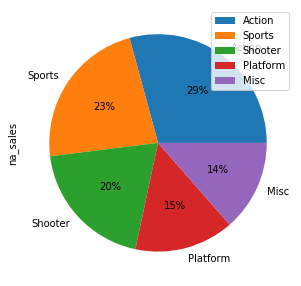

In [370]:
plot_top_sales_by_region_pie(df, 'genre', region = 'na_sales')

as we see most popular genre is an Action

#### EU / Europe

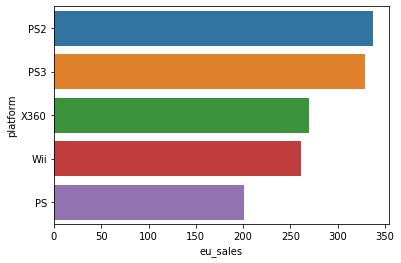

In [119]:
plot_top_sales_by_region(df, 'platform', region = 'eu_sales')

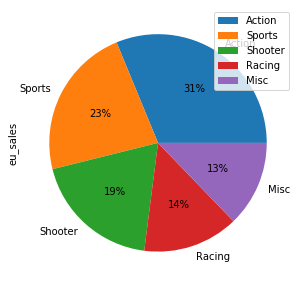

In [372]:
plot_top_sales_by_region_pie(df, 'genre', region = 'eu_sales')

similar picture to the USA, action and Sports. 

#### JP / Japan

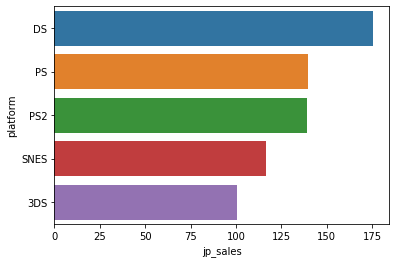

In [373]:
plot_top_sales_by_region(df, 'platform', region = 'jp_sales')

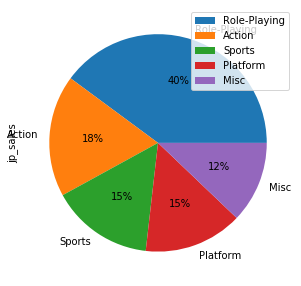

In [375]:
plot_top_sales_by_region_pie(df, 'genre', region = 'jp_sales')

in the Japan situation is different, RPG is most popular

### Summary

in the USA:
    * In the USA X360 is popular, second one is PS2. both of company have long story of competition at the USA market, Microsoft v Sony
    * Action/Sports and Shooter
in the Europe:
    * PS2/PS3
    * genre - action and Sports.
in the Japan:
    * DS and PS are popular console
    * RPG is the most popular genre
    

## 5. Test the following hypotheses:

In [451]:
#I think it could vary depends on how much data we deleted before, because it could impact on statistics
alpha = .05 

<div class="paragraph">—Average user ratings of the Xbox One and PC platforms are the same. </div><div class="paragraph">—Average user ratings for the Action and Sports genres are different.</div><div class="paragraph">Set the <em>alpha</em> threshold value yourself.</div><div class="paragraph">Explain:</div><div class="paragraph">—How you formulated the null and alternative hypotheses </div><div class="paragraph">—What significance level you chose to test the hypotheses, and why</div>

Let's check:
—Average user ratings of the Xbox One and PC platforms are the same.

$H_0$:—Average user ratings of the Xbox One and PC platforms are the same.

and

$H_1$: —Average user ratings of the Xbox One and PC platforms are different.   


In [455]:
df["platform"].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [462]:
H_0 = "Average user ratings of the Xbox One and PC platforms are the same."
H_1 = "Average user ratings of the Xbox One and PC platforms are different."

pc = df[df["platform"] == 'PC'].dropna()['user_score'].values
xbox = df[df["platform"].isin(["X360", "XOne", "XB"])].dropna()['user_score'].values

result = stats.ttest_ind(pc, xbox)
print('pvalue:', result.pvalue)

if (result.pvalue < alpha):
    print(H_1)
else:
    print(H_0)
print("checking:")
print(f"pc mean={pc.mean()}")
print(f"xbox mean={xbox.mean()}")

pvalue: 0.0007677407596063077
Average user ratings of the Xbox One and PC platforms are different.
checking:
pc mean=5.37381930184805
xbox mean=4.903343334762109


Let's check:
—Average user ratings of the Xbox One and PC platforms are the same.

$H_0$:—Average user ratings of the Xbox One and PC platforms are the same.

and

$H_1$: —Average user ratings for the Action and Sports genres are different.   


In [464]:
H_0 = "Average user ratings for the Action and Sports genres are the same."
H_1 = "Average user ratings for the Action and Sports genres are different."

action = df[df["genre"] == 'action'].dropna()['user_score'].values
sports = df[df["genre"] == 'sports'].dropna()['user_score'].values

result = stats.ttest_ind(action, sports)
print('pvalue:', result.pvalue)

if (result.pvalue < alpha):
    print(H_1)
else:
    print(H_0)
print("checking:")
print(f"action mean={action.mean()}")
print(f"sports mean={sports.mean()}")

pvalue: 1.2291505038512654e-08
Average user ratings for the Action and Sports genres are different.
checking:
action mean=3.376157957244656
sports mean=2.741457179377929


## 6. Write a general conclusion

* Platforms are before 2005, was gone. Others are still in the market but also in the process of disappearing.
* Most popular are PlayStation and Xbox. Most popular genre are Action, Shooter, except Japan, where RPG is most popular
* As we saw it's region specific business. 
* Average user ratings of the Xbox One and PC platforms are different.
* Average user ratings for the Action and Sports genres are different.
* Also need reserch specific platform, big gap between most popular platform and the others